In [26]:
import pandas as pd
import matplotlib.pyplot as plt

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster import hierarchy
from IPython.core.display import display, HTML

%pylab inline

plt.rcParams["font.family"] = 'serif'
plt.rcParams["font.size"] = '14'

display(HTML("<style>.container { width:98% !important; }</style>"))

Populating the interactive namespace from numpy and matplotlib


C:\Users\Francesca\Anaconda2\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['average']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [3]:
series = pd.Series.from_csv('ibm_daily_1962-2018.csv', sep='\t',header=0)

In [4]:
#divisione della serie in anni
#OUTPUT: mod_series (record divisi in anni), years_list (lista di anni)
def SeriesToYears(series):
    years_groups = series.groupby(pd.Grouper(freq='A'));
    
    mod_series = []
    years_list = []
    for name, group in years_groups:
        year_values = pd.Series((group.values - group.values.mean())/group.values.std()).rolling(window=4, min_periods=1).mean()
        year_values = year_values.dropna()
        year_values = year_values.reset_index(drop=True)
        mod_series.append(year_values)
        years_list.append(name.year)
    
    return mod_series, years_list

In [5]:
mod_series, years_list = SeriesToYears(series)
mod_series[1]

0     -2.140522
1     -2.222870
2     -2.110022
3     -2.053598
4     -1.989549
5     -1.824853
6     -1.753942
7     -1.667020
8     -1.568661
9     -1.470300
10    -1.381089
11    -1.355928
12    -1.301029
13    -1.317041
14    -1.321616
15    -1.271292
16    -1.266717
17    -1.234692
18    -1.182081
19    -1.092870
20    -1.024248
21    -0.992224
22    -0.955625
23    -0.962487
24    -0.976212
25    -0.962487
26    -1.005949
27    -1.049410
28    -1.051697
29    -1.081434
         ...   
221    1.446195
222    1.418746
223    1.350123
224    1.192289
225    1.055043
226    0.867472
227    0.727937
228    0.718787
229    0.773685
230    0.993280
231    1.238037
232    1.402734
233    1.462208
234    1.457633
235    1.389010
236    1.331823
237    1.299798
238    1.231175
239    1.146540
240    1.077916
241    1.045892
242    1.077917
243    1.153403
244    1.222026
245    1.276925
246    1.276925
247    1.299799
248    1.395872
249    1.505669
250    1.661215
Length: 251, dtype: floa

In [6]:
def dtw(x, y, dist):
    """
    Computes Dynamic Time Warping (DTW) of two sequences.

    :param array x: N1*M array
    :param array y: N2*M array
    :param func dist: distance used as cost measure

    Returns the minimum distance, the cost matrix, the accumulated cost matrix, and the wrap path.
    """
    assert len(x)
    assert len(y)
    r, c = len(x), len(y)
    
    # D0 = D1 = matrix of point-to-point costs
    D0 = zeros((r + 1, c + 1))
    D0[0, 1:] = inf
    D0[1:, 0] = inf
    D1 = D0[1:, 1:] # view (hide first column and first row)
    
    # Fill the point-to-point costs matrix
    for i in range(r):
        for j in range(c):
            D1[i, j] = dist(x[i], y[j])
            
    # C = matrix of optimal paths costs
    C = D1.copy()
    for i in range(r):
        for j in range(c):
            D1[i, j] += min(D0[i, j], D0[i, j+1], D0[i+1, j])
    
    # Infer the path from matrix C
    if len(x)==1:
        path = zeros(len(y)), range(len(y))  # special case 1
    elif len(y) == 1:
        path = range(len(x)), zeros(len(x))  # special case 2
    else:
        path = _traceback(D0)  # general case
        
    return D1[-1, -1], C, D1, path

# Function for inferring the optima path (general case)
# Starts from last cell and goes backward...
def _traceback(D):
    i, j = array(D.shape) - 2
    p, q = [i], [j]
    while ((i > 0) or (j > 0)):
        tb = argmin((D[i, j], D[i, j+1], D[i+1, j]))
        if (tb == 0):
            i -= 1
            j -= 1
        elif (tb == 1):
            i -= 1
        else: # (tb == 2):
            j -= 1
        p.insert(0, i)
        q.insert(0, j)
    return array(p), array(q)


def distance(x,y):
    return abs(x-y)

In [7]:
%%time

# CAUTION !!! CAN BE VERY SLOW !!!

# Compute upper half of matrix
dd1 = [ [ (dtw(mod_series[x],mod_series[y],distance)[0] \
           if y > x else -1)  \
         for y in range(len(years_list)) ] 
       for x in range(len(years_list)) ]
# Copy values also to the lower half, exployting symmetry of the distance function
dd2 = [ [ (dd1[x][y] if y > x else dd1[y][x])  for y in range(len(years_list)) ] for x in range(len(years_list)) ]
# Finally, the diagonal
for i in range(len(years_list)):
    dd2[i][i] = 0.0

Wall time: 40min 2s


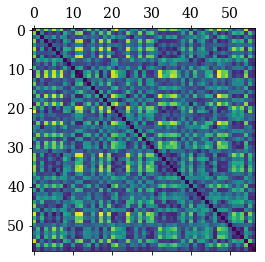

In [8]:
matshow(dd2, interpolation=None, aspect='auto')

# Calcolo Hierarchical Clustering

Calcolo con DTW:

In [108]:
single_linkage = linkage(dd2, method='single')
complete_linkage = linkage(dd2, method='complete')
average = linkage(dd2, method='average')

C:\Users\Francesca\Anaconda2\lib\site-packages\ipykernel_launcher.py:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  """Entry point for launching an IPython kernel.
C:\Users\Francesca\Anaconda2\lib\site-packages\ipykernel_launcher.py:2: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  
C:\Users\Francesca\Anaconda2\lib\site-packages\ipykernel_launcher.py:3: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  This is separate from the ipykernel package so we can avoid doing imports until


In [109]:
cmap = cm.gist_rainbow(np.linspace(0.1, 1, 7))
hierarchy.set_link_color_palette([mpl.colors.rgb2hex(rgb[:3]) for rgb in cmap])
matplotlib.rcParams['lines.linewidth'] = 2

In [110]:
def hier_lab(i): #funzione per la stampa dei nomi degli anni
    return years_list[i]

Visualizzazione Risultati:

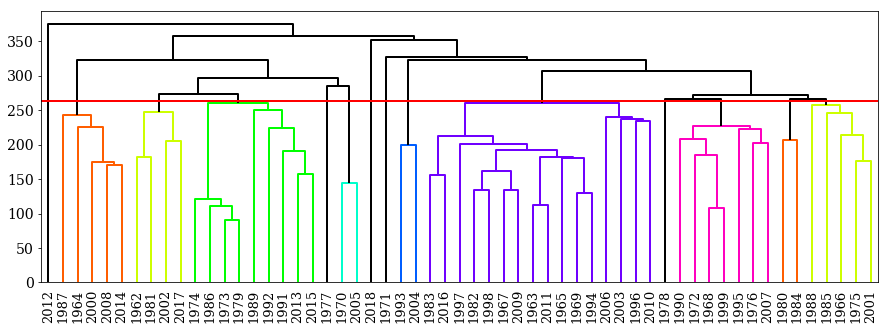

In [111]:
fig = plt.figure(figsize=(15, 5))
dn = dendrogram(single_linkage, color_threshold = 263, above_threshold_color  = '#000000', leaf_label_func = hier_lab)
plt.axhline(y=263, c='r')  
xticks(fontsize=13)

plt.savefig('Images/TimeSeries/HierarcSingle.png', format='png', bbox_inches='tight')

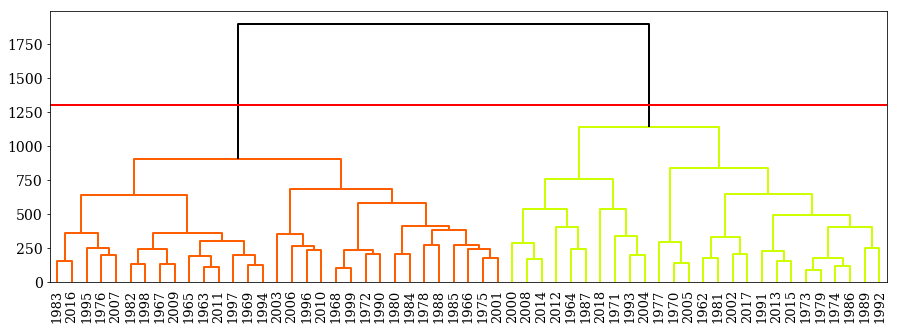

In [112]:
fig = plt.figure(figsize=(15, 5))
dn = dendrogram(complete_linkage, color_threshold = 1300, above_threshold_color  = '#000000', leaf_label_func = hier_lab)
plt.axhline(y=1300, c='r')
xticks(fontsize=13)

plt.savefig('Images/TimeSeries/HierarcComplete.png', format='png', bbox_inches='tight')

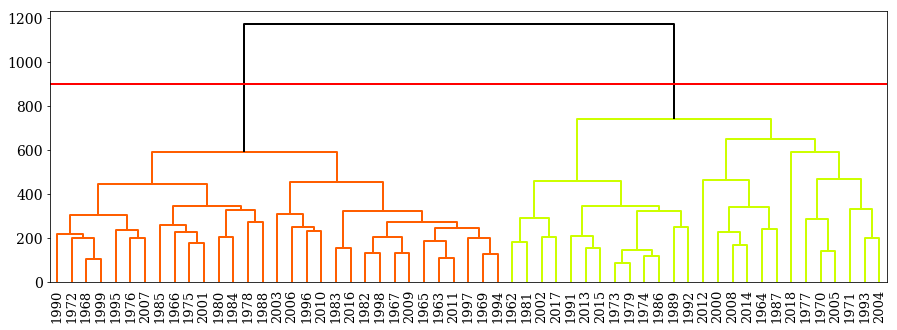

In [113]:
fig = plt.figure(figsize=(15, 5))
dn = dendrogram(average, color_threshold = 900, above_threshold_color  = '#000000', leaf_label_func = hier_lab)
plt.axhline(y=900, c='r')
xticks(fontsize=13)

plt.savefig('Images/TimeSeries/HierarcAVG.png', format='png', bbox_inches='tight')

In [42]:
print(complete_linkage)

[[  1.10000000e+01   1.70000000e+01   9.04929535e+01   2.00000000e+00]
 [  6.00000000e+00   3.70000000e+01   1.07659293e+02   2.00000000e+00]
 [  1.00000000e+00   4.90000000e+01   1.11726654e+02   2.00000000e+00]
 [  1.20000000e+01   2.40000000e+01   1.21329109e+02   2.00000000e+00]
 [  7.00000000e+00   3.20000000e+01   1.30132950e+02   2.00000000e+00]
 [  2.00000000e+01   3.60000000e+01   1.33611782e+02   2.00000000e+00]
 [  5.00000000e+00   4.70000000e+01   1.33699305e+02   2.00000000e+00]
 [  8.00000000e+00   4.30000000e+01   1.44335697e+02   2.00000000e+00]
 [  2.10000000e+01   5.40000000e+01   1.55922147e+02   2.00000000e+00]
 [  5.10000000e+01   5.30000000e+01   1.57944621e+02   2.00000000e+00]
 [  4.60000000e+01   5.20000000e+01   1.70989452e+02   2.00000000e+00]
 [  5.70000000e+01   6.00000000e+01   1.76006122e+02   4.00000000e+00]
 [  1.30000000e+01   3.90000000e+01   1.77002254e+02   2.00000000e+00]
 [  0.00000000e+00   1.90000000e+01   1.82802753e+02   2.00000000e+00]
 [  3.